## **GNR 650:** Advanced topics in deep learning for image analysis
### **Assignment 2:** Fine tuning a pre-trained Vision Transformer (B-12) on EuroSAT dataset
> The task is to use a pre-trained ViT like B-12, and prepare four models with the following fine-tuning strategies. Then visualize and compare the intermediate feature responses of all the four models using train/test split of the [EuroSAT](https://www.tensorflow.org/datasets/catalog/eurosat) dataset.
> 1. Fine tuning the final layer 
> 2. Fine tuning the bottom layers 
> 3. Full fine tune on the eurosat data 
> 4. No fine tuning

### Collaborators: 
[![Munish](https://img.shields.io/badge/22M2153-Munish_Monga-blue)](https://github.com/munish30monga)
[![Aniket](https://img.shields.io/badge/22M2162-Aniket_Thomas-darkgreen)](https://github.com/AniTho)

### Table of Contents:
1. [Introduction](#introduction)
2. [Imporing Libraries](#imporing-libraries)
3. [Hyperparameters](#hyperparameters)


### Introduction

### Imporing Libraries

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Subset
import timm
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

### Hyperparameters <a class="anchor" id="#hyperparameters"></a>

In [2]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inv_mean = -mean
inv_std = 1/std
batch_size = 32
learning_rate = 0.001
img_size = (224, 224)
val_size = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10
seed = 42                   # random seed
print_summary = False
base_model = 'vit_base_patch16_224'

### Downloading and Processing data

In [ ]:
# Run only once for downloading data
!sh download_eurosat.sh

In [3]:
base_dir = './data/eurosat/'
transform = transforms.Compose([transforms.Resize(img_size),
                            transforms.ToTensor(),
                            transforms.Normalize(mean, std),
                            ])

# For the purposes of visualizing images
inv_transforms = transforms.Compose([transforms.Normalize(mean = (0., 0., 0.),
                                                          std = inv_std),
                                     transforms.Normalize(mean = inv_mean,
                                                          std = (1., 1., 1,))])

complete_data = datasets.ImageFolder(root = base_dir, transform = transform)

# Creating subset for train and valid data
all_indices = list(range(len(complete_data)))
random.shuffle(all_indices)
valid_idxs = all_indices[:int(len(all_indices) * val_size)]
train_idxs = all_indices[int(len(all_indices) * val_size):]

train_data = Subset(complete_data, train_idxs)
valid_data = Subset(complete_data, valid_idxs)
trainloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, 
                        num_workers = 32)
validloader = DataLoader(valid_data, batch_size = batch_size, num_workers = 32)
print(f"Number of Total Samples: {len(complete_data)}")
print(f"Number of Train Samples: {len(train_data)}")
print(f"Number of Valid Samples: {len(valid_data)}")

Number of Total Samples: 27000
Number of Train Samples: 21600
Number of Valid Samples: 5400


In [4]:
unique_classes = complete_data.classes
print(f"Classes to classify: \n{unique_classes}")

Classes to classify: 
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


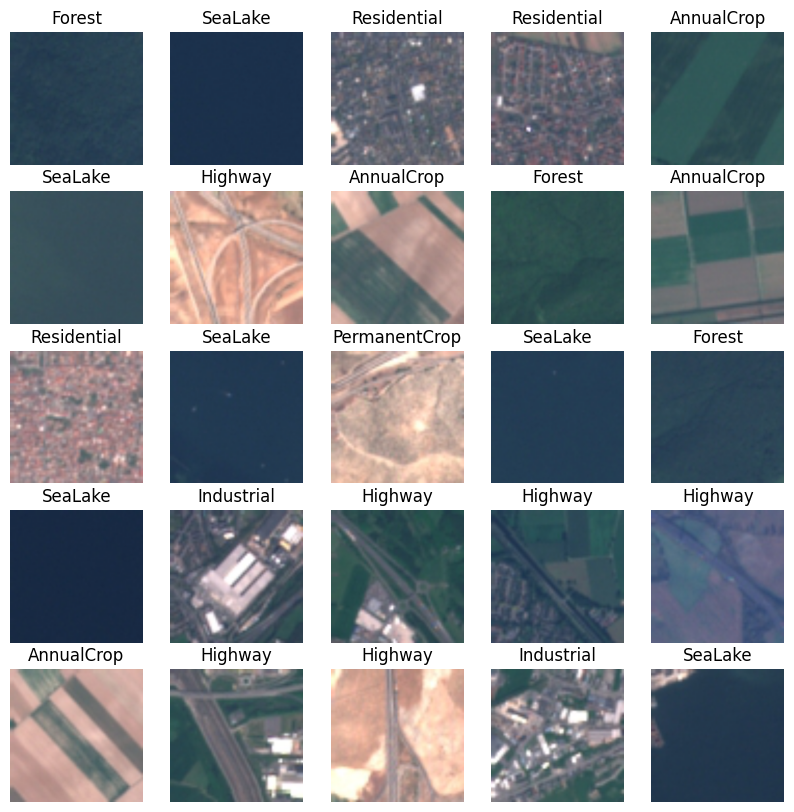

In [5]:
def visualize_tensor(images, targets, inv_transform, classes):
    if len(images) > 25:
        num_row, num_col = 5, 5
        fig, axes = plt.subplots(nrows = num_row, ncols = num_col,
                                figsize = (10,10))
    elif len(images) > 9:
        num_row, num_col = 3, 3
        fig, axes = plt.subplots(nrows = num_row, ncols = num_col,
                                figsize = (8,8))
    total_plots = num_row*num_col
    for i in range(total_plots):
        img = images[i]
        curr_class = classes[targets[i]]
        img = inv_transform(img)
        image = torch.permute(img, (1, 2, 0)).cpu().detach().numpy()
        curr_row = i // num_row
        curr_col = i % num_col
        axes[curr_row][curr_col].imshow(image)
        axes[curr_row][curr_col].set_title(curr_class)
        axes[curr_row][curr_col].axis('off')

images, targets = next(iter(trainloader))
visualize_tensor(images, targets, inv_transforms, unique_classes)

In [6]:
def build_model(base_model, classes = unique_classes, num_freeze = -2):
    '''
    base_model (str): Name of the model
    classes (list): List of all the class to classify
    num_freeze(int): Number of layers to freeze, if -2 will also freeze
                     custom head added to model and if -1 will not freeze
                     network head but all layers in base network
    '''
    num_class = len(classes)
    network = timm.create_model(base_model, pretrained = True)
    for idx, child in enumerate(network.children()):
        # Freeze all layers
        if num_freeze == -1 or num_freeze == -2:
            for param in child.parameters():
                param.requires_grad = False
            continue

        else:
            if idx >= num_freeze:
                break
            for param in child.parameters():
                param.requires_grad = False
    network.head = nn.Linear(in_features=network.head.in_features, 
                            out_features=num_class, bias=True)
    # Freezing Head
    if num_freeze == -2:
        for param in network.head.parameters():
            param.requires_grad = False
    return network

In [7]:
def train(trainloader, model, optimizer, criterion):
    pbar = tqdm(trainloader, total=len(trainloader), leave=False)
    epoch_loss = 0.0
    model.train()
    for imgs, lbls in pbar:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        pbar.set_postfix(train_loss=loss.item())
    epoch_loss /= len(trainloader)
    return epoch_loss

def calculate_accuracy_and_loss(dataloader, model, 
                                criterion = None):
    model.eval()
    no_of_correct, total = 0, 0
    curr_loss = 0.0
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            if criterion:
                loss = criterion(out, lbls)
                curr_loss += loss.item()
            _, preds = out.max(-1)
            no_of_correct += (preds == lbls).cpu().numpy().sum()
            total += len(lbls)

    accuracy = no_of_correct / total
    if criterion:
        curr_loss = curr_loss / len(dataloader)
        return curr_loss, accuracy
    return accuracy

def train_model(trainloader, validloader, model, print_summary, 
                epochs = 20, regularize = False, wd = 0.05):
    model = model.to(device)
    if print_summary:
        summary(model=model, input_size=(3,32,32))
    criterion = nn.CrossEntropyLoss()
    if regularize:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = wd)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    accuracy = []
    valid_losses = []
    valid_accuracy = []
    best_valid_accuracy = 0.0

    # Save Names
    best_model = f'best_model'

    for epoch in range(1, epochs+1):
        epoch_train_loss = train(trainloader, model, optimizer, criterion)
        train_accuracy = calculate_accuracy_and_loss(trainloader, model)
        train_losses.append(epoch_train_loss)
        accuracy.append(train_accuracy)

        valid_epoch_loss, valid_epoch_accuracy = \
            calculate_accuracy_and_loss(validloader, model, criterion)
        valid_losses.append(valid_epoch_loss)
        valid_accuracy.append(valid_epoch_accuracy)

        if best_valid_accuracy < valid_epoch_accuracy:
            best_valid_accuracy = valid_epoch_accuracy
            torch.save(model.state_dict(), f'./model_weights/{best_model}.pt')

        print(f"{'*'*10} EPOCH {epoch:2}/{epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}, Train Accuracy: {train_accuracy*100:5.2f}
Valid Loss: {valid_epoch_loss:5.3f}, Valid Accuracy: {valid_epoch_accuracy*100:5.2f}
{"#"*33}''')
    model.load_state_dict(torch.load(f'./model_weights/{best_model}.pt'))
    return model, train_losses, accuracy, valid_losses, valid_accuracy

### Train Model

#### 1. Fine Tuning final layer

In [8]:
network = build_model(base_model, unique_classes, -1)
model, train_losses, accuracy, valid_losses, valid_accuracy = \
    train_model(trainloader, validloader, network, print_summary, 
                epochs = epochs)


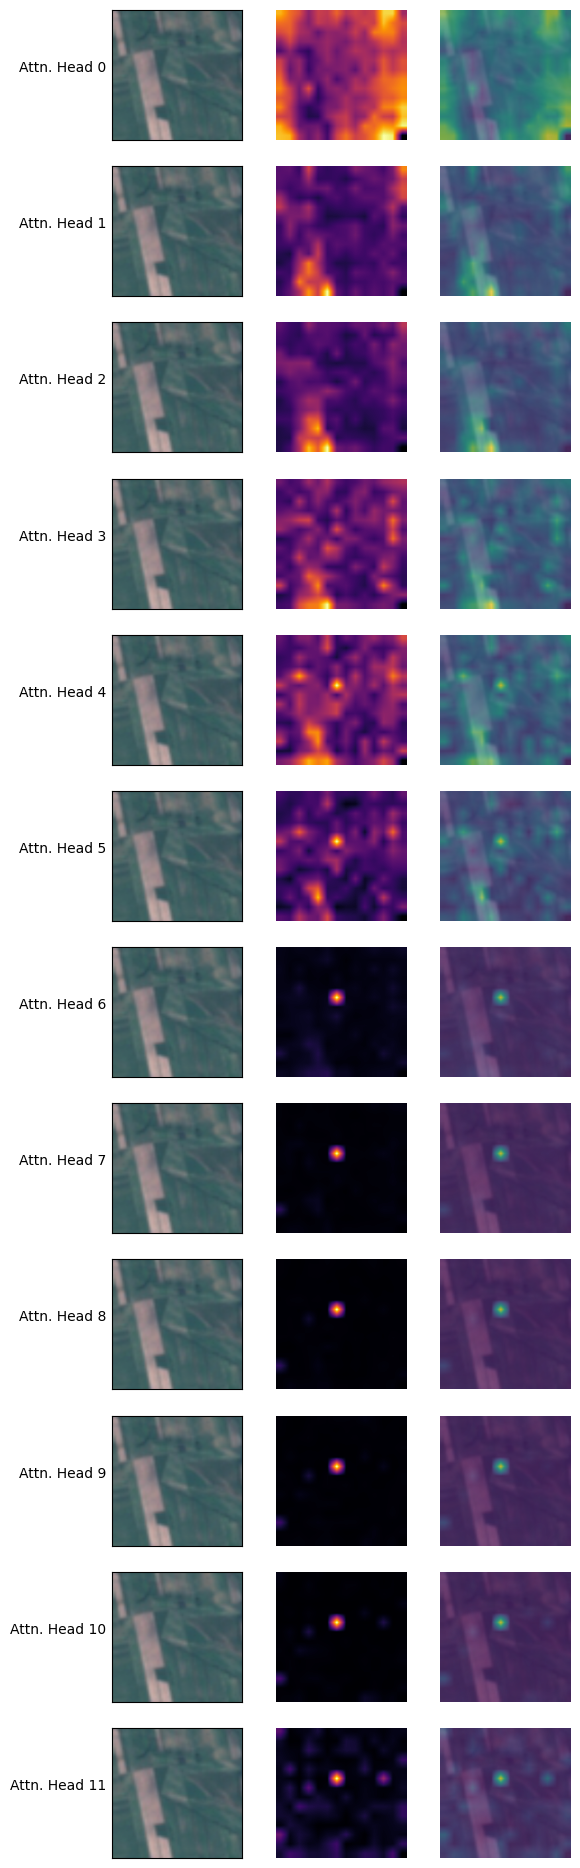

In [10]:
# Ref: https://github.com/huggingface/pytorch-image-models/discussions/1232
# Ref: https://github.com/facebookresearch/dino/blob/main/visualize_attention.py#L179
def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

def visualize_attention_layers(network, img):
    num_blocks = len(network.blocks)
    fig, axes = plt.subplots(nrows = num_blocks, ncols = 3,figsize = (6,24))
    if img.ndim != 4:
        img = img.unsqueeze(0)

    display_img = inv_transforms(img).detach()[0]
    display_img = torch.permute(display_img, (1,2,0))
    for i in range(num_blocks):
        network.blocks[i].attn.forward = my_forward_wrapper(network.blocks[i].attn)
        output = network(img)
        cls_weight = network.blocks[i].attn.cls_attn_map.mean(dim=1).detach()
        # In order to make 14x14 patch and then resize to 224x224
        zero = torch.tensor([[0.]])
        cls_weight = network.blocks[i].attn.cls_attn_map.mean(dim=1).detach()
        cls_weight = torch.cat([cls_weight, zero], dim = 1).view(14,14)
        cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), img_size, mode='bilinear').view(*img_size, 1)

        axes[i][0].imshow(display_img)
        axes[i][0].set_ylabel(f'Attn. Head {i}')
        axes[i][0].yaxis.label.set(rotation='horizontal', ha='right')
        axes[i][0].set_xticks([])
        axes[i][0].set_yticks([])
        axes[i][1].imshow(cls_resized, cmap = 'inferno')
        axes[i][1].axis('off')
        axes[i][2].imshow(display_img)
        axes[i][2].imshow(cls_resized, alpha = 0.6)
        axes[i][2].axis('off')

imgs, _ = next(iter(trainloader))
visualize_attention_layers(model, imgs[0])